#Music Genre Recognition

##Neural Networks And Deep Learning Final Project (A.Y. 2022/2023)

---
**University of Padua**<br>
*Master Degree in ICT for Internet and Multimedia - Cybersystems*
<br>
<br>
**Students:**
<br>


*   *Amerigo Aloisi*
*   *Jaswant Singh Bogan*
*   *Anna Zorzetto*
<br>

## Import packages



In [ ]:
# installs
!pip install librosa
!pip install python-dotenv
!pip install audiomentations


In [ ]:
# imports
import os
import time

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sn

import librosa
import librosa.display
import IPython.display as ipd
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Dataset analysis and preprocessing

### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/dataset/* ./


Mounted at /content/drive


In [ ]:
import utils
# Directory where mp3 are stored.
AUDIO_DIR = 'fma_small'
# Load metadata and features.
tracks = utils.load('fma_metadata/fma_metadata/fma_metadata/tracks.csv')

In [ ]:
# inspect dataset stats
print('{} tracks, {} artists, {} albums, {} genres'.format(
    len(tracks), len(tracks['artist', 'id'].unique()),
    len(tracks['album', 'id'].unique()),
    len(tracks['track','genre_top'].unique())))

106574 tracks, 16341 artists, 14854 albums, 17 genres


In [ ]:
# load the small subset
tracks = tracks[tracks['set', 'subset'] <= 'small']
tracks.shape

(8000, 52)

In [ ]:
# remove corrupted samples
corrupted_tracks = [98565, 98567, 98568, 98569, 99134, 108925, 133297]
tracks = tracks.drop(corrupted_tracks, axis=0, errors='ignore')
tracks.shape

(7994, 52)

In [ ]:
# split
train_dataset = tracks[tracks['set', 'split'] == 'training']
val_dataset = tracks[tracks['set', 'split'] == 'validation']
test_dataset = tracks[tracks['set', 'split'] == 'test']
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train_dataset, val_dataset, test_dataset])))


6394 training examples, 800 validation examples, 800 testing examples


In [ ]:
# extract key-values pairs
train_dataset = train_dataset[('track', 'genre_top')].to_dict()
val_dataset = val_dataset[('track', 'genre_top')].to_dict()
test_dataset = test_dataset[('track', 'genre_top')].to_dict()

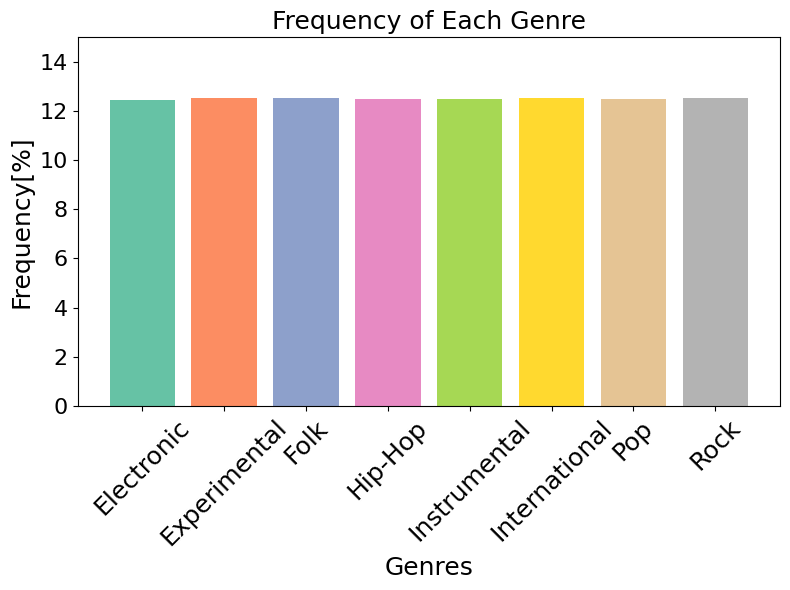

In [ ]:
# plot training distribution
label_counts = {}
for label in train_dataset.values():
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1
for key in label_counts:
    label_counts[key] = (label_counts[key]/len(train_dataset))*100

labels = sorted(label_counts.keys())

plt.figure(figsize=(8,6))
color_map = plt.get_cmap('Set2')
plt.bar(labels, label_counts.values(),color=color_map([i for i in range(8)]))
plt.xlabel('Genres',fontsize=18)
plt.ylabel('Frequency[%]',fontsize=18)
plt.title('Frequency of Each Genre',fontsize=18)
plt.xticks(fontsize = 18,rotation=45)
plt.yticks(fontsize=16)
plt.ylim(0, 15)
plt.tight_layout()
plt.show()

### Data Normalization

In [114]:
# compute mean and variance of the whole training set
def dataset_normalization(train_data):

  ids = np.array(list(train_data.keys()))
  lenght = len(ids)
  t_audio_mean, t_audio_std, t_mel_mean, t_mel_std, t_mfcc_mean, t_mfcc_std = 0,0,0,0,0,0
  for i in ids:
    audio_path = utils.get_audio_path(AUDIO_DIR, i)
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=4096, hop_length=1024, n_mels=128)
    S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=S)

    audio_mean = np.mean(y)
    audio_std =  np.std(y)
    mel_mean = np.sum(S, axis=1)/(S.shape[1])
    mel_std =  np.sqrt(np.sum((S - mel_mean[:,None])**2, axis=1)/(S.shape[1]))
    mfcc_mean = np.mean(mfcc)
    mfcc_std = np.std(mfcc)

    t_audio_mean += audio_mean
    t_audio_std +=  audio_std
    t_mel_mean += mel_mean
    t_mel_std += mel_std
    t_mfcc_mean += mfcc_mean
    t_mfcc_std += mfcc_std

  t_audio_mean = t_audio_mean/lenght
  t_audio_std =  t_audio_std/lenght
  t_mel_mean = [mean/lenght for mean in t_mel_mean]
  t_mel_std = [std/lenght for std in t_mel_std]
  t_mfcc_mean = t_mfcc_mean/lenght
  t_mfcc_std = t_mfcc_std/lenght


  np.save('./normalization/train_audio_mean.npy', t_audio_mean)
  np.save('./normalization/train_audio_std.npy', t_audio_std)
  np.save('./normalization/train_mel_mean.npy', t_mel_mean)
  np.save('./normalization/train_mel_std.npy', t_mel_std)
  np.save('./normalization/train_mfcc_mean.npy', t_mfcc_mean)
  np.save('./normalization/train_mfcc_std.npy', t_mfcc_std)

In [ ]:
#dataset_normalization(train_dataset)

### Data Augmentation

In [ ]:
# data augmentation
audio_transform = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
])

### Raw Audio Dataset class


In [ ]:
# custom audio dataset class
class RawAudioDataset(Dataset):

    def __init__(self, data, transform=None):

        self.ids = np.array(list(data.keys()))
        le = LabelEncoder()
        self.labels = le.fit_transform(np.array(list(data.values())))
        self.genre = list(le.classes_)
        self.transform = transform
        self.sr = 44100 # normalize the sampling rate

    def __len__(self):
        return len(self.ids)

    def load_audio (self,i):
        filename = utils.get_audio_path(AUDIO_DIR, self.ids[i])
        x, sr = librosa.load(filename, sr=None, mono=True)
        x = librosa.resample(x,orig_sr=sr,target_sr=self.sr)
        # from each 30s sample get a random sample of about 6s, performs also as data augmentation
        start = np.random.randint(0, x.shape[0]-2**18)
        x = x [start:(start+2**18)]
        return x

    def plot_audio (self,i):
        x = self.load_audio(i)
        plt.figure(figsize=(8,6))
        librosa.display.waveshow(x, sr=self.sr, alpha=0.5, zorder=2)
        plt.ylim(-1,1)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('Time [s]', fontsize=18)
        plt.ylabel('Amplitude', fontsize=18)
        plt.title('Waveform', fontsize=18)
        plt.grid(ls='--', zorder=1)
        plt.show()

    def play_audio(self,i):
        x = self.load_audio(i)
        return ipd.Audio(data=x,rate=self.sr)

    def __getitem__(self, i):

        x = self.load_audio(i)

        # data augmentation
        if self.transform:
            x = self.transform(x,self.sr)

        # downsample to half the input size
        x = librosa.resample(x,orig_sr=self.sr,target_sr=self.sr/2)

        x = x.reshape(1,-1)
        return  torch.from_numpy(x), torch.tensor(self.labels[i])

In [ ]:
audio = RawAudioDataset(train_dataset)

In [ ]:
x,y = audio.__getitem__(1)
x.shape # channels x samples

torch.Size([1, 131072])

In [115]:
audio.play_audio(1)

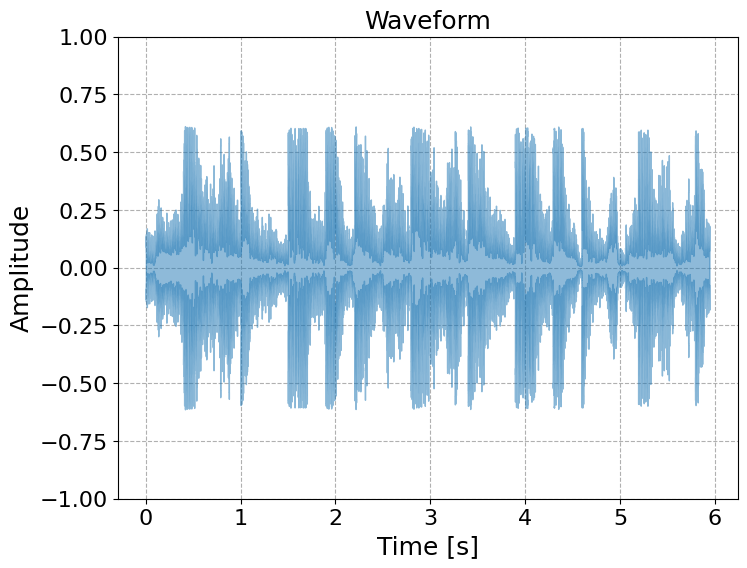

In [ ]:
audio.plot_audio(1)

### Log Mel-Spectrogram Dataset class

In [129]:
# custom spectrogram dataset class
class MelSpectrogramDataset(RawAudioDataset):

    def __init__(self, data, transform=None):
        super().__init__(data=data, transform=transform)

    def load_spectrogram(self,i):

        x = self.load_audio(i)
        # data augmnentation
        if self.transform:
            x = self.transform(x,self.sr)

        mel = librosa.feature.melspectrogram(y=x, sr=self.sr, n_fft=2048, hop_length=512, n_mels=128)[:,:512]
        mel= librosa.power_to_db(mel, ref=np.max)
        return mel

    def plot_spectrogram(self,i):

        mel = self.load_spectrogram(i)
        plt.figure(figsize=(8,6))
        img = librosa.display.specshow(mel, sr=self.sr, hop_length=512, x_axis='time', y_axis='mel')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('Time [s]', fontsize=18)
        plt.ylabel('Frequency [Hz]', fontsize=18)
        plt.title('Log mel-spectrogram', fontsize=20)
        cbar = plt.colorbar(img)
        cbar.ax.set_ylim(-80, 0)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label('dB', size=18)
        plt.show()

    def __getitem__(self, i):

        mel = self.load_spectrogram(i)
        return  torch.from_numpy(mel).unsqueeze(0), torch.tensor(self.labels[i])

In [130]:
spectrogram = MelSpectrogramDataset(train_dataset)

In [131]:
mel,y = spectrogram.__getitem__(2)
print(mel.shape)

torch.Size([1, 128, 512])


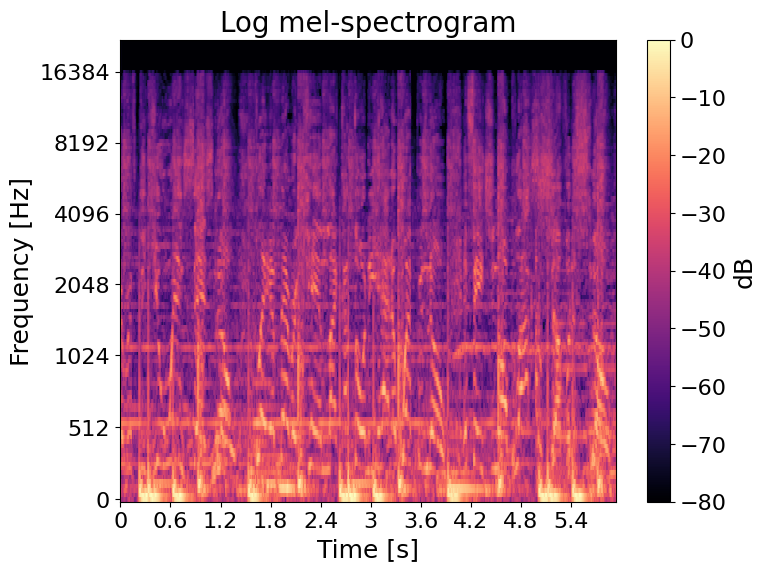

In [132]:
spectrogram.plot_spectrogram(1)

### Mel Cepstrum Coefficients Dataset Class


In [137]:
class MFCCDataset(MelSpectrogramDataset):

    def __init__(self, data, transform=None, multimodal=False):
        super().__init__(data=data, transform=transform)
        self.multimodal = multimodal

    def load_mfcc(self,i):

        x = self.load_audio(i)
        # data augmnentation
        if self.transform:
            x = self.transform(x,self.sr)
        mfcc = librosa.feature.mfcc(y=x, n_fft=2048, hop_length=512)[:,:512]
        return mfcc

    def plot_mfcc(self,i):

        mfcc = self.load_mfcc(i)
        plt.figure(figsize=(8,6))
        img = librosa.display.specshow(mfcc, sr=self.sr, x_axis='time');
        plt.xticks(fontsize=16)
        plt.xlabel('Time [s]', fontsize=18)
        plt.title('Mel-Frequency Cepstrum Coefficients', fontsize=16)
        cbar = plt.colorbar(img)
        cbar.ax.tick_params(labelsize=16)
        plt.show()

    def __getitem__(self, i):

        mfcc= torch.from_numpy(self.load_mfcc(i)).unsqueeze(0)

        if self.multimodal:
          x = torch.from_numpy(librosa.resample(
              self.load_audio(i),orig_sr=self.sr,target_sr=self.sr/2).reshape(1,-1))
          mel = torch.from_numpy(self.load_spectrogram(i)).unsqueeze(0)
          return (x,mel,mfcc),torch.tensor(self.labels[i])
        else:
          return mfcc,torch.tensor(self.labels[i])

In [138]:
mfcc = MFCCDataset(train_dataset,multimodal='True')
x_mfcc,y = mfcc.__getitem__(1)

In [135]:
print(x_mfcc[0].shape,x_mfcc[1].shape,x_mfcc[2].shape)

torch.Size([1, 131072]) torch.Size([1, 128, 512]) torch.Size([1, 20, 512])


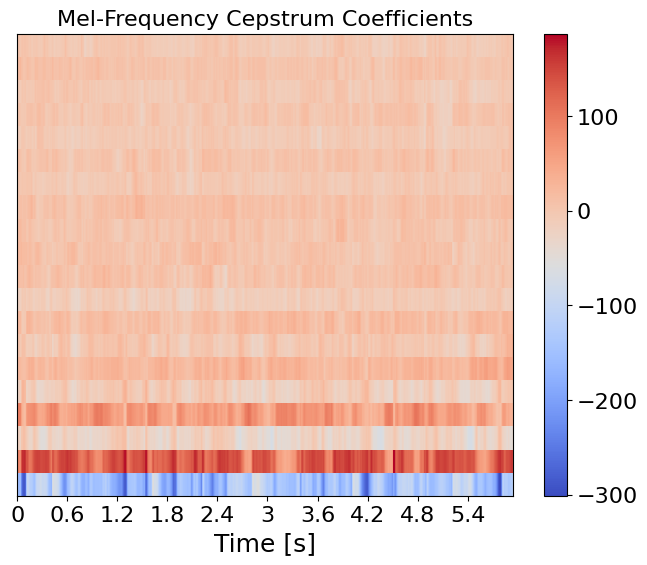

In [139]:
mfcc.plot_mfcc(1)

## Baseline models

### 1D Audio CNN

In [ ]:
# conv 1_D

# reference paper: End-to-end environmental sound classification using a 1D convolutional neural network

# input: [1,131072] channels x n_samples

class ConvBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class ConvLayers1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock1d(1,16,64,2,32),
            nn.MaxPool1d(kernel_size=8,stride=8),
            ConvBlock1d(16,32,32,2,16),
            nn.MaxPool1d(kernel_size=4,stride=4),
            ConvBlock1d(32,64,16,2,8),
            nn.MaxPool1d(kernel_size=4,stride=4),
            ConvBlock1d(64,128,8,2,4)

        )
    def forward(self,x):
        return self.layers(x)


class RawAudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(1)
        self.avg_pool = nn.MaxPool1d(kernel_size=64)
        self.max_pool = nn.AvgPool1d(kernel_size=64)
        self.conv_layers = ConvLayers1d()
        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(64,8),
        )
    def forward(self, x):
        x = self.conv_layers(self.batch_norm(x))
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = torch.cat([x_avg, x_max], dim = 1)
        return self.classifier(x.reshape((x.shape[0], -1)))

print(RawAudioCNN())

RawAudioCNN(
  (batch_norm): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): MaxPool1d(kernel_size=64, stride=64, padding=0, dilation=1, ceil_mode=False)
  (max_pool): AvgPool1d(kernel_size=(64,), stride=(64,), padding=(0,))
  (conv_layers): ConvLayers1d(
    (layers): Sequential(
      (0): ConvBlock1d(
        (block): Sequential(
          (0): Conv1d(1, 16, kernel_size=(64,), stride=(2,), padding=(32,))
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock1d(
        (block): Sequential(
          (0): Conv1d(16, 32, kernel_size=(32,), stride=(2,), padding=(16,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (3): MaxPool1d(kernel_size=4

In [ ]:
model = RawAudioCNN()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 158106


### 2D Log Mel-Spectrogram CNN

In [ ]:
# conv 2_D

# reference paper: Improved Music Genre Classification with Convolutional Neural Networks

# input: [1,128,512]

class ConvBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size= kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class MelConvLayers(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock2d(1,16,3,1),
            nn.MaxPool2d(kernel_size=[4,8]),
            ConvBlock2d(16,32,3,1),
            nn.MaxPool2d(kernel_size=[4,8]),
            ConvBlock2d(32,64,3,1),
            nn.MaxPool2d(kernel_size=[4,4]),
            ConvBlock2d(64,128,3,1),
        )
    def forward(self,x):
        return self.layers(x)

class MelSpecCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_norm = nn.BatchNorm2d(1)
        self.avg_pool = nn.MaxPool2d(kernel_size=[2,2])
        self.max_pool = nn.AvgPool2d(kernel_size=[2,2])

        self.conv_layers = MelConvLayers()
        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(64,8)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = torch.cat([x_avg, x_max], dim = 1)
        return self.classifier(x.reshape((x.shape[0], -1)))

print(MelSpecCNN())

MelSpecCNN(
  (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (max_pool): AvgPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0)
  (conv_layers): MelConvLayers(
    (layers): Sequential(
      (0): ConvBlock2d(
        (block): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=[4, 8], stride=[4, 8], padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock2d(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (3)

In [ ]:
model = MelSpecCNN()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 139306


## Proposed models


### Mel Cepstrum Coefficients 2D CNN

In [ ]:
# mfcc conv 2d

# input: [1, 20, 512]

class MfccConvLayers(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock2d(1,16,3,1),
            nn.MaxPool2d(kernel_size=[2,2]),
            ConvBlock2d(16,32,3,1),
            nn.MaxPool2d(kernel_size=[2,2]),
            ConvBlock2d(32,64,3,1),
            nn.MaxPool2d([3,2]),
            ConvBlock2d(64,128,3,1), # 128x1x64
        )
    def forward(self,x):
        return self.layers(x)

class MfccCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_norm = nn.BatchNorm2d(1)
        self.avg_pool = nn.MaxPool2d(kernel_size=[1,64])
        self.max_pool = nn.AvgPool2d(kernel_size=[1,64])
        self.conv_layers = MfccConvLayers()
        self.classifier = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(64,8),
        )

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.conv_layers(x)
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = torch.cat([x_avg, x_max], dim = 1)
        return self.classifier(x.reshape((x.shape[0], -1)))

print(MfccCNN())

MfccCNN(
  (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): MaxPool2d(kernel_size=[1, 64], stride=[1, 64], padding=0, dilation=1, ceil_mode=False)
  (max_pool): AvgPool2d(kernel_size=[1, 64], stride=[1, 64], padding=0)
  (conv_layers): MfccConvLayers(
    (layers): Sequential(
      (0): ConvBlock2d(
        (block): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock2d(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (

In [ ]:
model = MfccCNN()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 139306


### Late Fusion RCNN

In [ ]:
# combined model: 1d and 2d, late fusion
# reference paper: A Short Survey and Comparison of CNN-Based Music Genre Classification Using Multiple Spectral Features

class LateFusionNetwork(nn.Module):
  def __init__(self):
        super().__init__()
        self.audio = ConvLayers1d()
        self.mfcc = MfccConvLayers()
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.dropout = nn.Dropout(p=0.4)
        self.classifier = nn.Linear(128,8)

  def forward(self,x_1,x_2,x_3):
      x_1 = self.audio(x_1)
      x_1 = x_1[:,:,None,:64]
      x_3 = self.mfcc(x_3)
      x = torch.cat([x_1,x_3], dim=1)
      x = x.reshape((x.shape[0], x.shape[3], x.shape[1]))
      out, _ = self.lstm(x)
      out = self.dropout(out[:,-1,:])
      return self.classifier(out)

In [ ]:
model = LateFusionNetwork()
total_params = sum(p.numel() for p in model.parameters())
print('Number of parameters:', total_params)

Number of parameters: 412728


### EnsembleClassifier

In [ ]:
class EnsembleClassifier(nn.Module):

  def __init__(self,mode):
    super().__init__()
    self.audio_model = RawAudioCNN()
    self.mel_model = MelSpecCNN()
    self.mfcc_model = MfccCNN()
    self.fusion_model = LateFusionNetwork()
    self.mode = mode

  def forward(self,x1,x2,x3):
    if (self.mode == 1):
      y1 = self.audio_model(x1)
      y2 = self.mel_model(x2)
      y3 = self.mfcc_model(x3)
      y = (y1+y2+y3)/3
      return y
    elif (self.mode == 2):
      y1 = self.fusion_model(x1,x2,x3)
      y2 = self.mel_model(x2)
      y = (y1+y2)/3
      return y

## Functions for training and testing


In [ ]:
def CM_elements(y_logits,y):

    y_prob = F.softmax(y_logits, dim=1)
    y_pred = y_prob.argmax(dim=1)

    y_pred_bool = F.one_hot(y_pred, num_classes=8).bool()
    y_bool = F.one_hot(y, num_classes=8).bool()

    # logical_and is element wise 'and', zeros element are always false
    # 0 == 0 -> False
    TP = torch.sum(torch.logical_and(y_pred_bool, y_bool), dim=0)
    FP = torch.sum(y_pred_bool, dim=0) - TP
    TN = torch.sum(torch.logical_and(~y_pred_bool, ~y_bool), dim=0)
    FN = torch.sum(~y_pred_bool, dim=0) - TN

    return TP, FP, TN, FN


In [ ]:
def compute_metrics(loss, TP, FP, TN, FN):

    # loss
    loss = loss

    # accuracy and macro-averaging accuracy
    accuracy = (TP + TN)/(TP + FP + TN + FN)
    MA_accuracy = torch.sum(accuracy)/8

    # precision and macro-averaging precision
    precision = TP/(TP + FP)
    MA_precision = torch.sum(precision)/8

    # recall and macro-averaging recall
    recall = TP/(TP + FN)
    MA_recall = torch.sum(recall)/8

    # F1-score and macro-averaging F1-score
    F1_score = 2*(precision*recall)/(precision + recall)
    MA_F1_score = 2*(MA_precision*MA_recall)/(MA_precision + MA_recall)

    metrics = {
        'loss': loss.item(),
        'accuracy': accuracy.tolist(),
        'MA_accuracy': MA_accuracy.item(),
        'precision': precision.tolist(),
        'MA_precision': MA_precision.item(),
        'recall': recall.tolist(),
        'MA_recall': MA_recall.item(),
        'F1_score': F1_score.tolist(),
        'MA_F1_score': MA_F1_score.item()
    }

    return metrics

In [ ]:
def train (model, iterator, criterion, optimizer, device, desc = 'train'):

    epoch_loss = 0

    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    model.train()

    for x, y in tqdm(iterator, desc=desc):

        # set gradients to zero
        optimizer.zero_grad()

        if type(x) is list:
            # move data to the GPU
          x[0] = x[0].to(device)
          x[1] = x[1].to(device)
          x[2] = x[2].to(device)
          # make predictions
          y_pred = model(x[0],x[1],x[2])

        else:
          # move data to the GPU
          x = x.to(device)
          # make predictions
          y_pred = model(x)

        # move data to the GPU
        y = y.to(device)

        # compute loss
        loss = criterion(y_pred, y)

        # compute confusion matrix elements
        TP, FP, TN, FN = CM_elements(y_pred, y)

        # compute gradients
        loss.backward()

        # update the weights according to the optimizer using the gradients
        optimizer.step()

        # update loss
        epoch_loss += loss/len(iterator)

        # update confusion matrix elements
        epoch_TP += TP
        epoch_FP += FP
        epoch_TN += TN
        epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics

In [ ]:
def evaluate(model, iterator, criterion, device, desc='Valid'):

    epoch_loss = 0

    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    # set evaluation mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():

        # loop over batches
        for x, y in tqdm(iterator, desc=desc):

          if type(x) is list:
            # move data to the GPU
            x[0] = x[0].to(device)
            x[1] = x[1].to(device)
            x[2] = x[2].to(device)
            # make predictions
            y_pred = model(x[0],x[1],x[2])
          else:
            # move data to the GPU
            x = x.to(device)
            # make predictions
            y_pred = model(x)

          # move data to the GPU
          y = y.to(device)

          # compute loss
          loss = criterion(y_pred, y)

          # compute confusion matrix elements
          TP, FP, TN, FN = CM_elements(y_pred,y)

          # update loss
          epoch_loss += loss/len(iterator)

          # update confusion matrix elements
          epoch_TP += TP
          epoch_FP += FP
          epoch_TN += TN
          epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics

In [ ]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [ ]:
def training_loop (n_epochs, model, train_iterator, valid_iterator, criterion, optimizer, device, patience,
                   checkpoint_name='checkpoint.pt', results_name='results.csv'):

  train_metrics_log = {}
  valid_metrics_log = {}
  early_stopping = EarlyStopping(patience=patience)

  for epoch in range(n_epochs):

    print(f'\nEpoch: {epoch + 1}/{n_epochs}\n')

    start_time = time.time()
    # training
    train_metrics = train(model, train_iterator, criterion, optimizer, device, desc='Train')
    # validation
    valid_metrics = evaluate(model, valid_iterator, criterion, device, desc='Valid')

    print(f"\nTrain:", \
              f"Loss = {train_metrics['loss']:.4f},", \
              f"MA_acc = {train_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {train_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {train_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {train_metrics['MA_F1_score']*100:.2f} %")


    print(f"Valid:", \
              f"Loss = {valid_metrics['loss']:.4f},", \
              f"MA_acc = {valid_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {valid_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {valid_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {valid_metrics['MA_F1_score']*100:.2f} %")

    end_time = time.time()

    print(f'\nEpoch Time: {end_time-start_time:.2f} s\n')

    # save epoch metrics

    for key in train_metrics.keys():
            if key not in train_metrics_log:
                train_metrics_log[key] = []
            train_metrics_log[key].append(train_metrics[key])

    pd.DataFrame.from_dict(train_metrics_log).to_csv('train_'+results_name, index=False)

    # save valid metrics

    for key in valid_metrics.keys():
            if key not in valid_metrics_log:
                valid_metrics_log[key] = []
            valid_metrics_log[key].append(valid_metrics[key])

    pd.DataFrame.from_dict(valid_metrics_log).to_csv('valid_'+results_name, index=False)


    # check early stopping condition
    valid_loss = valid_metrics['loss']


    if early_stopping.early_stop(valid_loss):
      print ("Early stopping")
      break

  torch.save({
      'epoch' : epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
  }, checkpoint_name)

In [ ]:
# functions for testing
def test(model, iterator, criterion, device, desc='Test'):

    loss = 0
    CM = 0

    # set evaluation mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():

        # loop over batches
        for x, y in tqdm(iterator, desc=desc):

            if type(x) is list:
                # move data to the GPU
                x[0] = x[0].to(device)
                x[1] = x[1].to(device)
                x[2] = x[2].to(device)
                # make predictions
                y_logits = model(x[0], x[1], x[2])
            else:
                # move data to the GPU
                x = x.to(device)
                # make predictions
                y_logits = model(x)

            # move data to the GPU
            y = y.to(device)

            # compute loss
            loss = criterion(y_logits, y)

            # get one hot prediction
            y_prob = F.softmax(y_logits, dim=1)
            y_pred = y_prob.argmax(dim=1)

            # update loss
            loss += loss/len(iterator)

            # update confusion matrix (CPU)
            CM += confusion_matrix(y.view(-1).tolist(), y_pred.view(-1).tolist(), labels=range(8))

    # move loss from GPU to CPU
    loss = loss.cpu()

    # compute TP, FP, TN, FN
    TP = CM.diagonal().copy()
    CM_no_diag = CM - np.diag(TP)
    FP = CM_no_diag.sum(axis=0)
    FN = CM_no_diag.sum(axis=1)
    TN = CM.sum() - (FP + FN + TP)

    # transfrom from numpy to tensor (CPU)
    TP = torch.from_numpy(TP)
    FP = torch.from_numpy(FP)
    TN = torch.from_numpy(TN)
    FN = torch.from_numpy(FN)

    metrics = compute_metrics(loss, TP, FP, TN, FN)

    return metrics, CM

In [ ]:
def testing(model, iterator,criterion, device,results_name = 'results.csv',CM_name = 'confusion_matrix.csv'):

  metrics_log = {}

  metrics,CM = test(model, iterator, criterion, device, desc='Test')

  print(f"\nTest:", \
              f"Loss = {metrics['loss']:.4f},", \
              f"MA_acc = {metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {metrics['MA_F1_score']*100:.2f} %")

  for key in metrics.keys():
    if key not in metrics_log:
      metrics_log[key] = []
      metrics_log[key].append(metrics[key])

  pd.DataFrame.from_dict(metrics_log).to_csv(results_name, index=False)
  pd.DataFrame(CM).to_csv(CM_name, index=False)


In [ ]:
# functions to plot results
def plot_metrics(path):

  #Load data from csv file
  df_e = pd.read_csv(path)

  # Set larger figure size for subplots
  plt.figure(figsize=(10, 10))
  plot_titles = ['Loss', 'MA_Accuracy', 'MA_Precision', 'MA_Recall', 'MA_F1_Score']

  # Plot all graphs in a 3x2 grid
  for i, title in enumerate(plot_titles, 1):
      plt.subplot(3, 2, i)
      plt.plot(df_e['Epoch'], df_e[f'Train_{title}'], label='Train', marker='o')
      plt.plot(df_e['Epoch'], df_e[f'Valid_{title}'], label='Valid', marker='o')
      plt.title(title)
      plt.xlabel('Epoch')
      plt.ylabel(title)
      plt.legend()
      plt.grid(True)

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_CM(matrix_file='confusion_matrix.csv', plot_title='Confusion Matrix'):
    # Load and normalize the confusion matrix
    confusion_data = pd.read_csv(matrix_file).values
    normalized_data = normalize(confusion_data, axis=1, norm='l1')

    # Determine unique genres for labels
    genre_labels = np.unique(audio.genre)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    heatmap_ax = sn.heatmap(normalized_data, xticklabels=genre_labels, yticklabels=genre_labels,
                             vmin=0, vmax=1, cmap='Blues', annot=True, fmt='.2f')

    # Customize the appearance
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14, rotation=0)
    plt.xlabel('Predicted Genres', fontsize=16)
    plt.ylabel('Actual Genres', fontsize=16)
    plt.title(plot_title, fontsize=18)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## Training

### 1D Audio CNN

In [ ]:
train_1d = RawAudioDataset(train_dataset, transform=audio_transform)
valid_1d = RawAudioDataset(val_dataset, transform=audio_transform)
test_1d = RawAudioDataset(test_dataset, transform=audio_transform)

In [ ]:
BATCH_SIZE = 32
# create iterators
train_iterator = DataLoader(train_1d, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_iterator = DataLoader(valid_1d, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_iterator = DataLoader(test_1d, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda


In [ ]:
model = RawAudioCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
training_loop(n_epochs,model,train_iterator,valid_iterator,criterion,optimizer,device,patience=3,checkpoint_name='audio_checkpoint.pt',results_name='audio_results.csv')

### 2D Mel-Spectrogram CNN

In [ ]:
train_mel = MelSpectrogramDataset(train_dataset, transform=audio_transform)
valid_mel = MelSpectrogramDataset(val_dataset, transform=audio_transform)
test_mel = MelSpectrogramDataset(test_dataset, transform=audio_transform)

In [ ]:
BATCH_SIZE = 32
# create iterators
train_mel_iterator = DataLoader(train_mel, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_mel_iterator = DataLoader(valid_mel, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_mel_iterator = DataLoader(test_mel, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda


In [ ]:
# training loop
model = MelSpecCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
training_loop(n_epochs,model,train_mel_iterator,valid_mel_iterator,criterion,optimizer,device,patience=3,checkpoint_name='mel_checkpoint.pt',results_name='mel_results.csv')


Epoch: 1/20



Valid: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it]



Train: Loss = 1.8319, MA_acc = 82.36 %, MA_prec = 27.63 %, MA_rec = 29.46 %, MA_F1_score = 28.52 %
Valid: Loss = 1.7962, MA_acc = 83.25 %, MA_prec = 34.47 %, MA_rec = 33.00 %, MA_F1_score = 33.72 %

Epoch Time: 690.23 s


Epoch: 2/20



Valid: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]



Train: Loss = 1.6886, MA_acc = 84.23 %, MA_prec = 34.95 %, MA_rec = 36.94 %, MA_F1_score = 35.92 %
Valid: Loss = 1.8232, MA_acc = 82.84 %, MA_prec = 33.93 %, MA_rec = 31.37 %, MA_F1_score = 32.60 %

Epoch Time: 686.52 s


Epoch: 3/20



Valid: 100%|██████████| 25/25 [01:24<00:00,  3.38s/it]



Train: Loss = 1.6246, MA_acc = 85.39 %, MA_prec = 39.65 %, MA_rec = 41.56 %, MA_F1_score = 40.58 %
Valid: Loss = 1.5426, MA_acc = 86.09 %, MA_prec = 39.26 %, MA_rec = 44.37 %, MA_F1_score = 41.66 %

Epoch Time: 696.82 s


Epoch: 4/20



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.27s/it]



Train: Loss = 1.5604, MA_acc = 86.10 %, MA_prec = 42.32 %, MA_rec = 44.43 %, MA_F1_score = 43.35 %
Valid: Loss = 1.6382, MA_acc = 85.37 %, MA_prec = 40.44 %, MA_rec = 41.50 %, MA_F1_score = 40.96 %

Epoch Time: 696.96 s


Epoch: 5/20



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.28s/it]



Train: Loss = 1.5294, MA_acc = 86.54 %, MA_prec = 44.02 %, MA_rec = 46.18 %, MA_F1_score = 45.07 %
Valid: Loss = 1.8763, MA_acc = 84.78 %, MA_prec = 37.24 %, MA_rec = 39.13 %, MA_F1_score = 38.16 %

Epoch Time: 692.93 s


Epoch: 6/20



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it]



Train: Loss = 1.5066, MA_acc = 86.71 %, MA_prec = 45.06 %, MA_rec = 46.86 %, MA_F1_score = 45.94 %
Valid: Loss = 1.5423, MA_acc = 86.22 %, MA_prec = 44.60 %, MA_rec = 44.88 %, MA_F1_score = 44.74 %

Epoch Time: 694.47 s


Epoch: 7/20



Valid: 100%|██████████| 25/25 [01:24<00:00,  3.38s/it]



Train: Loss = 1.4959, MA_acc = 86.75 %, MA_prec = 45.44 %, MA_rec = 47.01 %, MA_F1_score = 46.21 %
Valid: Loss = 1.6563, MA_acc = 85.28 %, MA_prec = 44.54 %, MA_rec = 41.12 %, MA_F1_score = 42.77 %

Epoch Time: 696.52 s


Epoch: 8/20



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it]



Train: Loss = 1.4672, MA_acc = 87.25 %, MA_prec = 47.57 %, MA_rec = 49.03 %, MA_F1_score = 48.29 %
Valid: Loss = 1.5352, MA_acc = 85.69 %, MA_prec = 48.78 %, MA_rec = 42.75 %, MA_F1_score = 45.57 %

Epoch Time: 686.53 s


Epoch: 9/20



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it]



Train: Loss = 1.4442, MA_acc = 87.29 %, MA_prec = 47.96 %, MA_rec = 49.15 %, MA_F1_score = 48.55 %
Valid: Loss = 1.5261, MA_acc = 87.03 %, MA_prec = 48.86 %, MA_rec = 48.13 %, MA_F1_score = 48.49 %

Epoch Time: 695.51 s


Epoch: 10/20



Valid: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it]



Train: Loss = 1.4250, MA_acc = 87.54 %, MA_prec = 48.79 %, MA_rec = 50.16 %, MA_F1_score = 49.46 %
Valid: Loss = 1.4394, MA_acc = 87.53 %, MA_prec = 49.28 %, MA_rec = 50.13 %, MA_F1_score = 49.70 %

Epoch Time: 690.59 s


Epoch: 11/20



Valid: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it]



Train: Loss = 1.4239, MA_acc = 87.61 %, MA_prec = 49.25 %, MA_rec = 50.44 %, MA_F1_score = 49.84 %
Valid: Loss = 1.4591, MA_acc = 86.81 %, MA_prec = 49.19 %, MA_rec = 47.25 %, MA_F1_score = 48.20 %

Epoch Time: 691.67 s


Epoch: 12/20



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it]



Train: Loss = 1.4061, MA_acc = 87.65 %, MA_prec = 49.39 %, MA_rec = 50.62 %, MA_F1_score = 50.00 %
Valid: Loss = 1.4298, MA_acc = 87.94 %, MA_prec = 49.63 %, MA_rec = 51.75 %, MA_F1_score = 50.67 %

Epoch Time: 694.66 s


Epoch: 13/20



Valid: 100%|██████████| 25/25 [01:19<00:00,  3.20s/it]



Train: Loss = 1.4016, MA_acc = 87.95 %, MA_prec = 50.73 %, MA_rec = 51.80 %, MA_F1_score = 51.26 %
Valid: Loss = 1.4142, MA_acc = 87.56 %, MA_prec = 50.17 %, MA_rec = 50.25 %, MA_F1_score = 50.21 %

Epoch Time: 692.81 s


Epoch: 14/20



Valid: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it]



Train: Loss = 1.3642, MA_acc = 88.22 %, MA_prec = 51.59 %, MA_rec = 52.89 %, MA_F1_score = 52.23 %
Valid: Loss = 1.5109, MA_acc = 86.63 %, MA_prec = 51.56 %, MA_rec = 46.50 %, MA_F1_score = 48.90 %

Epoch Time: 687.96 s


Epoch: 15/20



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it]



Train: Loss = 1.3622, MA_acc = 88.39 %, MA_prec = 52.51 %, MA_rec = 53.56 %, MA_F1_score = 53.03 %
Valid: Loss = 1.3735, MA_acc = 88.44 %, MA_prec = 51.72 %, MA_rec = 53.75 %, MA_F1_score = 52.72 %

Epoch Time: 696.53 s


Epoch: 16/20



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it]



Train: Loss = 1.3625, MA_acc = 88.14 %, MA_prec = 51.58 %, MA_rec = 52.57 %, MA_F1_score = 52.07 %
Valid: Loss = 1.4747, MA_acc = 86.63 %, MA_prec = 49.38 %, MA_rec = 46.50 %, MA_F1_score = 47.90 %

Epoch Time: 701.69 s


Epoch: 17/20



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it]



Train: Loss = 1.3570, MA_acc = 88.30 %, MA_prec = 52.06 %, MA_rec = 53.20 %, MA_F1_score = 52.62 %
Valid: Loss = 1.5942, MA_acc = 87.25 %, MA_prec = 49.46 %, MA_rec = 49.00 %, MA_F1_score = 49.23 %

Epoch Time: 695.11 s


Epoch: 18/20



Valid: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it]



Train: Loss = 1.3381, MA_acc = 88.54 %, MA_prec = 52.89 %, MA_rec = 54.14 %, MA_F1_score = 53.51 %
Valid: Loss = 1.3635, MA_acc = 87.66 %, MA_prec = 49.43 %, MA_rec = 50.63 %, MA_F1_score = 50.02 %

Epoch Time: 687.89 s


Epoch: 19/20



Valid: 100%|██████████| 25/25 [01:24<00:00,  3.36s/it]



Train: Loss = 1.3488, MA_acc = 88.34 %, MA_prec = 52.48 %, MA_rec = 53.40 %, MA_F1_score = 52.93 %
Valid: Loss = 1.4772, MA_acc = 87.38 %, MA_prec = 52.76 %, MA_rec = 49.50 %, MA_F1_score = 51.08 %

Epoch Time: 701.80 s


Epoch: 20/20



Valid: 100%|██████████| 25/25 [01:25<00:00,  3.40s/it]


Train: Loss = 1.3356, MA_acc = 88.51 %, MA_prec = 53.07 %, MA_rec = 54.03 %, MA_F1_score = 53.55 %
Valid: Loss = 1.4158, MA_acc = 87.91 %, MA_prec = 49.55 %, MA_rec = 51.63 %, MA_F1_score = 50.57 %

Epoch Time: 715.42 s



### 2D MFCC-CNN

In [ ]:
train_mfcc = MFCCDataset(train_dataset, transform=audio_transform)
valid_mfcc = MFCCDataset(val_dataset, transform=audio_transform)
test_mfcc = MFCCDataset(test_dataset, transform=audio_transform)

In [ ]:
BATCH_SIZE = 32
# create iterators
train_mfcc_iterator = DataLoader(train_mfcc, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_mfcc_iterator = DataLoader(valid_mfcc, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_mfcc_iterator = DataLoader(test_mfcc, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda


In [ ]:
# training loop
model = MfccCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 15

training_loop(n_epochs,model,train_mfcc_iterator,valid_mfcc_iterator,criterion,optimizer,device,patience=3,checkpoint_name='mfcc_checkpoint.pt',results_name='mfcc_results.csv')


Epoch: 1/15



Valid: 100%|██████████| 25/25 [01:24<00:00,  3.38s/it]



Train: Loss = 1.8674, MA_acc = 82.15 %, MA_prec = 26.49 %, MA_rec = 28.57 %, MA_F1_score = 27.49 %
Valid: Loss = 1.7047, MA_acc = 84.06 %, MA_prec = 34.33 %, MA_rec = 36.25 %, MA_F1_score = 35.26 %

Epoch Time: 707.23 s


Epoch: 2/15



Valid: 100%|██████████| 25/25 [01:18<00:00,  3.15s/it]



Train: Loss = 1.7206, MA_acc = 84.19 %, MA_prec = 34.40 %, MA_rec = 36.77 %, MA_F1_score = 35.55 %
Valid: Loss = 1.6558, MA_acc = 84.63 %, MA_prec = 37.88 %, MA_rec = 38.50 %, MA_F1_score = 38.19 %

Epoch Time: 706.76 s


Epoch: 3/15



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it]



Train: Loss = 1.6486, MA_acc = 85.09 %, MA_prec = 38.50 %, MA_rec = 40.40 %, MA_F1_score = 39.42 %
Valid: Loss = 1.5772, MA_acc = 85.41 %, MA_prec = 40.66 %, MA_rec = 41.62 %, MA_F1_score = 41.14 %

Epoch Time: 693.08 s


Epoch: 4/15



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it]



Train: Loss = 1.6097, MA_acc = 85.48 %, MA_prec = 39.78 %, MA_rec = 41.92 %, MA_F1_score = 40.82 %
Valid: Loss = 1.5624, MA_acc = 85.91 %, MA_prec = 46.04 %, MA_rec = 43.62 %, MA_F1_score = 44.80 %

Epoch Time: 690.19 s


Epoch: 5/15



Valid: 100%|██████████| 25/25 [01:23<00:00,  3.33s/it]



Train: Loss = 1.5693, MA_acc = 85.85 %, MA_prec = 41.10 %, MA_rec = 43.38 %, MA_F1_score = 42.21 %
Valid: Loss = 1.5215, MA_acc = 86.87 %, MA_prec = 47.85 %, MA_rec = 47.50 %, MA_F1_score = 47.67 %

Epoch Time: 689.65 s


Epoch: 6/15



Valid: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]



Train: Loss = 1.5313, MA_acc = 86.38 %, MA_prec = 43.89 %, MA_rec = 45.51 %, MA_F1_score = 44.69 %
Valid: Loss = 1.6912, MA_acc = 85.06 %, MA_prec = 43.32 %, MA_rec = 40.25 %, MA_F1_score = 41.73 %

Epoch Time: 695.79 s


Epoch: 7/15



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.30s/it]



Train: Loss = 1.5253, MA_acc = 86.57 %, MA_prec = 44.86 %, MA_rec = 46.27 %, MA_F1_score = 45.55 %
Valid: Loss = 1.5122, MA_acc = 86.47 %, MA_prec = 47.65 %, MA_rec = 45.88 %, MA_F1_score = 46.75 %

Epoch Time: 690.82 s


Epoch: 8/15



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it]



Train: Loss = 1.4957, MA_acc = 86.64 %, MA_prec = 45.13 %, MA_rec = 46.56 %, MA_F1_score = 45.84 %
Valid: Loss = 1.5300, MA_acc = 86.94 %, MA_prec = 46.46 %, MA_rec = 47.75 %, MA_F1_score = 47.10 %

Epoch Time: 691.18 s


Epoch: 9/15



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it]



Train: Loss = 1.4818, MA_acc = 86.83 %, MA_prec = 46.00 %, MA_rec = 47.33 %, MA_F1_score = 46.65 %
Valid: Loss = 1.4997, MA_acc = 86.63 %, MA_prec = 45.76 %, MA_rec = 46.50 %, MA_F1_score = 46.13 %

Epoch Time: 692.80 s


Epoch: 10/15



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it]



Train: Loss = 1.4660, MA_acc = 87.04 %, MA_prec = 46.45 %, MA_rec = 48.16 %, MA_F1_score = 47.29 %
Valid: Loss = 1.4887, MA_acc = 86.75 %, MA_prec = 46.45 %, MA_rec = 47.00 %, MA_F1_score = 46.72 %

Epoch Time: 690.94 s


Epoch: 11/15



Valid: 100%|██████████| 25/25 [01:20<00:00,  3.23s/it]



Train: Loss = 1.4477, MA_acc = 87.10 %, MA_prec = 46.87 %, MA_rec = 48.43 %, MA_F1_score = 47.64 %
Valid: Loss = 1.4260, MA_acc = 87.09 %, MA_prec = 46.65 %, MA_rec = 48.37 %, MA_F1_score = 47.50 %

Epoch Time: 697.81 s


Epoch: 12/15



Valid: 100%|██████████| 25/25 [01:22<00:00,  3.31s/it]



Train: Loss = 1.4308, MA_acc = 87.55 %, MA_prec = 49.06 %, MA_rec = 50.22 %, MA_F1_score = 49.63 %
Valid: Loss = 1.4526, MA_acc = 87.16 %, MA_prec = 47.31 %, MA_rec = 48.62 %, MA_F1_score = 47.96 %

Epoch Time: 701.80 s


Epoch: 13/15



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it]



Train: Loss = 1.4113, MA_acc = 87.65 %, MA_prec = 49.57 %, MA_rec = 50.62 %, MA_F1_score = 50.09 %
Valid: Loss = 1.4915, MA_acc = 87.03 %, MA_prec = 46.80 %, MA_rec = 48.12 %, MA_F1_score = 47.45 %

Epoch Time: 692.11 s


Epoch: 14/15



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.25s/it]



Train: Loss = 1.4055, MA_acc = 87.57 %, MA_prec = 49.19 %, MA_rec = 50.30 %, MA_F1_score = 49.73 %
Valid: Loss = 1.4256, MA_acc = 87.87 %, MA_prec = 48.31 %, MA_rec = 51.50 %, MA_F1_score = 49.85 %

Epoch Time: 694.46 s


Epoch: 15/15



Valid: 100%|██████████| 25/25 [01:21<00:00,  3.24s/it]


Train: Loss = 1.3798, MA_acc = 87.72 %, MA_prec = 49.60 %, MA_rec = 50.88 %, MA_F1_score = 50.23 %
Valid: Loss = 1.4680, MA_acc = 86.94 %, MA_prec = 46.11 %, MA_rec = 47.75 %, MA_F1_score = 46.91 %

Epoch Time: 687.97 s



### Late Fusion Network

In [ ]:
train_fusion = MFCCDataset(train_dataset, transform=audio_transform,multimodal='True')
valid_fusion = MFCCDataset(val_dataset, transform=audio_transform,multimodal='True')
test_fusion = MFCCDataset(test_dataset, transform=audio_transform,multimodal='True')

In [ ]:
BATCH_SIZE = 32
# create iterators
train_fusion_iterator = DataLoader(train_fusion, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count(), shuffle=True)
valid_fusion_iterator = DataLoader(valid_fusion, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())
test_fusion_iterator = DataLoader(test_fusion, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda


In [ ]:
# training loop
model = LateFusionNetwork()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10
training_loop(n_epochs,model,train_fusion_iterator,valid_fusion_iterator,criterion,optimizer,device,patience=2,checkpoint_name='checkpoint_fusion.pt',results_name='results_fusion.csv')


Epoch: 1/10



Train: 100%|██████████| 199/199 [19:26<00:00,  5.86s/it]



Train: Loss = 1.9137, MA_acc = 81.43 %, MA_prec = 24.29 %, MA_rec = 25.69 %, MA_F1_score = 24.97 %


Valid: 100%|██████████| 25/25 [02:45<00:00,  6.64s/it]


Valid: Loss = 1.7683, MA_acc = 83.53 %, MA_prec = 31.54 %, MA_rec = 34.13 %, MA_F1_score = 32.78 %

Epoch Time: 1332.19 s


Epoch: 2/10



Train: 100%|██████████| 199/199 [19:42<00:00,  5.94s/it]



Train: Loss = 1.7650, MA_acc = 83.53 %, MA_prec = 31.63 %, MA_rec = 34.14 %, MA_F1_score = 32.84 %


Valid: 100%|██████████| 25/25 [02:38<00:00,  6.34s/it]


Valid: Loss = 1.6889, MA_acc = 84.03 %, MA_prec = 33.77 %, MA_rec = 36.12 %, MA_F1_score = 34.91 %

Epoch Time: 1341.50 s


Epoch: 3/10



Train: 100%|██████████| 199/199 [19:26<00:00,  5.86s/it]



Train: Loss = 1.6886, MA_acc = 84.50 %, MA_prec = 35.45 %, MA_rec = 38.01 %, MA_F1_score = 36.69 %


Valid: 100%|██████████| 25/25 [02:39<00:00,  6.37s/it]


Valid: Loss = 1.6484, MA_acc = 84.62 %, MA_prec = 36.89 %, MA_rec = 38.50 %, MA_F1_score = 37.68 %

Epoch Time: 1325.36 s


Epoch: 4/10



Train: 100%|██████████| 199/199 [19:47<00:00,  5.97s/it]



Train: Loss = 1.6240, MA_acc = 85.23 %, MA_prec = 38.24 %, MA_rec = 40.94 %, MA_F1_score = 39.54 %


Valid: 100%|██████████| 25/25 [02:39<00:00,  6.37s/it]


Valid: Loss = 1.6152, MA_acc = 84.81 %, MA_prec = 38.13 %, MA_rec = 39.25 %, MA_F1_score = 38.68 %

Epoch Time: 1346.50 s


Epoch: 5/10



Train: 100%|██████████| 199/199 [19:52<00:00,  5.99s/it]



Train: Loss = 1.5949, MA_acc = 85.65 %, MA_prec = 40.40 %, MA_rec = 42.61 %, MA_F1_score = 41.48 %


Valid: 100%|██████████| 25/25 [02:40<00:00,  6.41s/it]


Valid: Loss = 1.5787, MA_acc = 85.84 %, MA_prec = 43.90 %, MA_rec = 43.37 %, MA_F1_score = 43.64 %

Epoch Time: 1352.81 s


Epoch: 6/10



Train: 100%|██████████| 199/199 [19:49<00:00,  5.98s/it]



Train: Loss = 1.5756, MA_acc = 85.93 %, MA_prec = 42.11 %, MA_rec = 43.69 %, MA_F1_score = 42.89 %


Valid: 100%|██████████| 25/25 [02:40<00:00,  6.43s/it]


Valid: Loss = 1.6915, MA_acc = 84.09 %, MA_prec = 36.83 %, MA_rec = 36.37 %, MA_F1_score = 36.60 %

Epoch Time: 1349.82 s


Epoch: 7/10



Train: 100%|██████████| 199/199 [19:50<00:00,  5.98s/it]



Train: Loss = 1.5485, MA_acc = 86.08 %, MA_prec = 42.57 %, MA_rec = 44.33 %, MA_F1_score = 43.43 %


Valid: 100%|██████████| 25/25 [02:42<00:00,  6.49s/it]


Valid: Loss = 1.5653, MA_acc = 85.50 %, MA_prec = 40.09 %, MA_rec = 42.00 %, MA_F1_score = 41.02 %

Epoch Time: 1352.99 s


Epoch: 8/10



Train: 100%|██████████| 199/199 [19:40<00:00,  5.93s/it]



Train: Loss = 1.5225, MA_acc = 86.24 %, MA_prec = 43.26 %, MA_rec = 44.95 %, MA_F1_score = 44.09 %


Valid: 100%|██████████| 25/25 [02:38<00:00,  6.33s/it]


Valid: Loss = 1.5840, MA_acc = 85.22 %, MA_prec = 40.84 %, MA_rec = 40.87 %, MA_F1_score = 40.86 %

Epoch Time: 1338.72 s


Epoch: 9/10



Train: 100%|██████████| 199/199 [19:51<00:00,  5.99s/it]



Train: Loss = 1.5070, MA_acc = 86.69 %, MA_prec = 45.31 %, MA_rec = 46.74 %, MA_F1_score = 46.02 %


Valid: 100%|██████████| 25/25 [02:40<00:00,  6.41s/it]

Valid: Loss = 1.5791, MA_acc = 85.13 %, MA_prec = 38.04 %, MA_rec = 40.50 %, MA_F1_score = 39.23 %

Epoch Time: 1351.24 s

Early stopping


## Inference

### Raw Audio CNN


In [ ]:
audio_checkpoint = torch.load('audio_checkpoint.pt')
model_state_dict = audio_checkpoint['model_state_dict']
model = RawAudioCNN()
model.load_state_dict(model_state_dict)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
testing(model,test_iterator,criterion,device)

Test: 100%|██████████| 25/25 [02:34<00:00,  6.18s/it]


Test: Loss = 1.6621, MA_acc = 83.66 %, MA_prec = 37.35 %, MA_rec = 34.62 %, MA_F1_score = 35.94 %


### Log Mel Spectrogram CNN

In [ ]:
mel_checkpoint = torch.load('mel_checkpoint.pt')
model_state_dict = mel_checkpoint['model_state_dict']
model = MelSpecCNN()
model.load_state_dict(model_state_dict)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
testing(model,test_mel_iterator,criterion,device)

Test: 100%|██████████| 25/25 [01:24<00:00,  3.39s/it]


Test: Loss = 1.1597, MA_acc = 86.84 %, MA_prec = 47.90 %, MA_rec = 47.38 %, MA_F1_score = 47.64 %


### MFCC CNN

In [ ]:
mfcc_checkpoint = torch.load('mfcc_checkpoint_2.pt')
model_state_dict = mfcc_checkpoint['model_state_dict']
model = MfccCNN()
model.load_state_dict(model_state_dict)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
testing(model,test_mfcc_iterator,criterion,device,results_name = 'results_mfcc.csv',CM_name = 'confusion_matrix_mfcc.csv')

Test: 100%|██████████| 25/25 [03:45<00:00,  9.03s/it]


Test: Loss = 1.2794, MA_acc = 85.47 %, MA_prec = 41.37 %, MA_rec = 41.88 %, MA_F1_score = 41.62 %


### Late Fusion RCNN

In [107]:
fusion_checkpoint = torch.load('fusion_checkpoint.pt')
model_state_dict = fusion_checkpoint['model_state_dict']
model = LateFusionNetwork()
model.load_state_dict(model_state_dict)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [108]:
testing(model,test_fusion_iterator,criterion,device,results_name = 'results_fusion.csv',CM_name = 'confusion_matrix_fusion.csv')

Test: 100%|██████████| 25/25 [08:53<00:00, 21.33s/it]


Test: Loss = 1.5541, MA_acc = 84.53 %, MA_prec = 38.63 %, MA_rec = 38.12 %, MA_F1_score = 38.38 %


### Ensemble model


#### Conv1d + Mel Conv2d + MFCC Conv2d

In [ ]:
# load pre trained models
audio_checkpoint = torch.load('audio_checkpoint.pt')
mel_checkpoint = torch.load('mel_checkpoint.pt')
mfcc_checkpoint = torch.load('mfcc_checkpoint_2.pt')
model = EnsembleClassifier(mode=1)
model.audio_model.load_state_dict(audio_checkpoint['model_state_dict'])
model.mel_model.load_state_dict(mel_checkpoint['model_state_dict'])
model.mfcc_model.load_state_dict(mfcc_checkpoint['model_state_dict'])


<All keys matched successfully>

In [ ]:
BATCH_SIZE = 32
test_set = MFCCDataset(test_dataset, transform=audio_transform, multimodal='True')
test_iterator = DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
testing(model,test_iterator,criterion,device,results_name = 'results_sum1.csv',CM_name = 'confusion_matrix_sum1.csv')

Test: 100%|██████████| 25/25 [07:11<00:00, 17.24s/it]


Test: Loss = 1.0247, MA_acc = 87.03 %, MA_prec = 47.56 %, MA_rec = 48.12 %, MA_F1_score = 47.84 %


#### Mel Conv 2d + Late Fusion RCNN

In [ ]:
# load pre trained models
audio_checkpoint = torch.load('audio_checkpoint.pt')
fusion_checkpoint = torch.load('fusion_checkpoint.pt')
model = EnsembleClassifier(mode=2)
model.audio_model.load_state_dict(audio_checkpoint['model_state_dict'])
model.fusion_model.load_state_dict(fusion_checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
BATCH_SIZE = 32
test_set = MFCCDataset(test_dataset, transform=audio_transform, multimodal='True')
test_iterator = DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=True, num_workers=os.cpu_count())

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
testing(model,test_iterator,criterion,device,results_name = 'results_sum2.csv',CM_name = 'confusion_matrix_sum2.csv')

Test: 100%|██████████| 25/25 [07:10<00:00, 17.22s/it]


Test: Loss = 1.8183, MA_acc = 84.25 %, MA_prec = 35.35 %, MA_rec = 37.00 %, MA_F1_score = 36.15 %


## Results


###1D Audio CNN


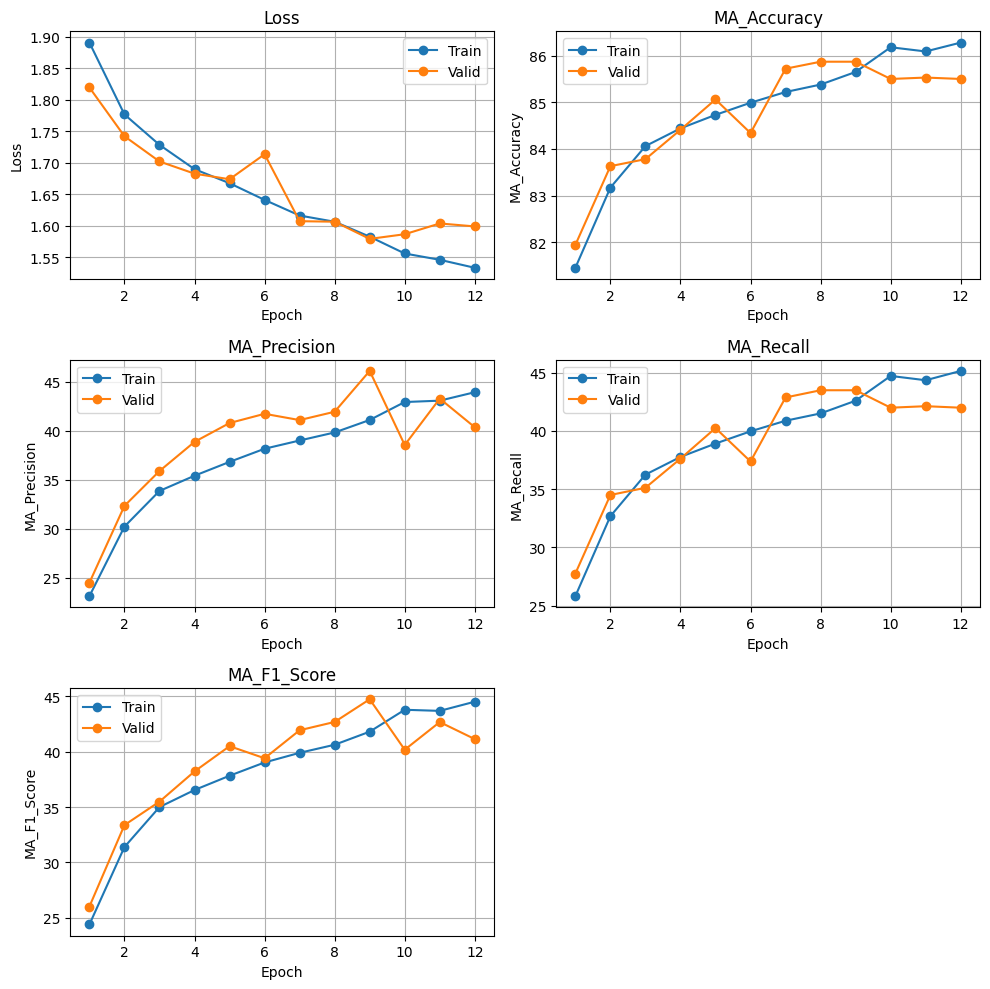

In [ ]:
plot_metrics('1D_data.csv')

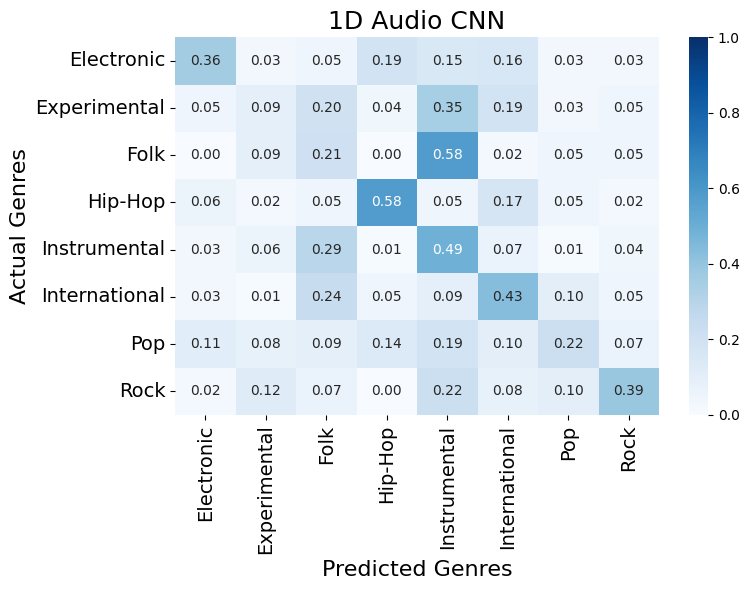

In [ ]:
plot_CM(matrix_file='audio_confusion_matrix.csv', plot_title='1D Audio CNN')

###2D Mel-Spectrogram CNN

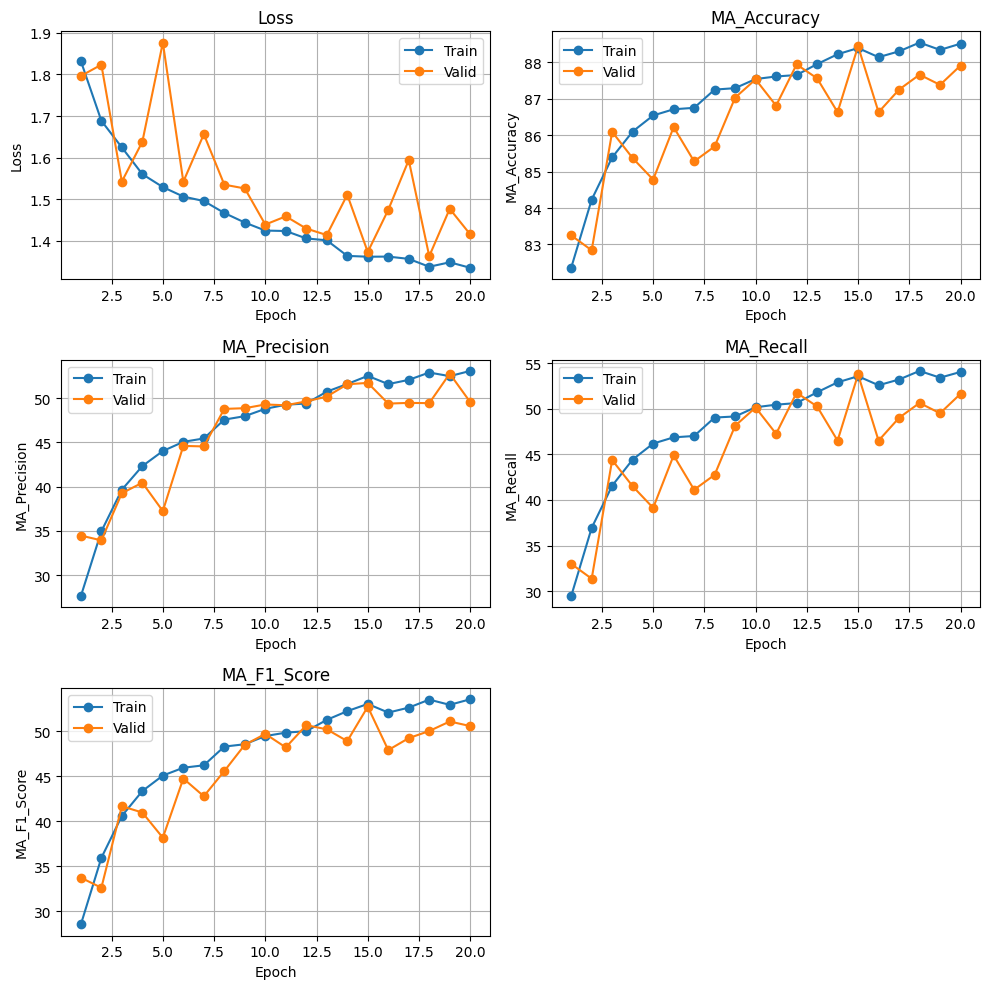

In [ ]:
plot_metrics('MelSpec_data.csv')

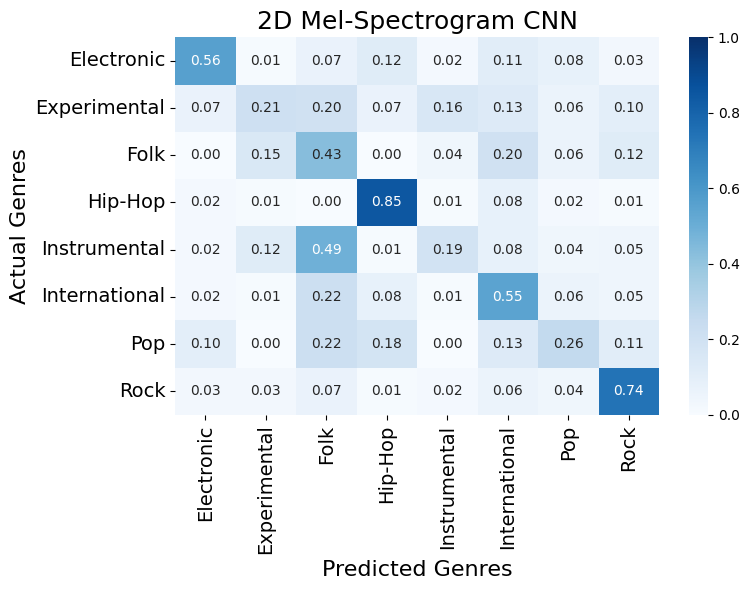

In [ ]:
plot_CM(matrix_file='mel_confusion_matrix.csv', plot_title='2D Mel-Spectrogram CNN')

###2D MFCC CNN

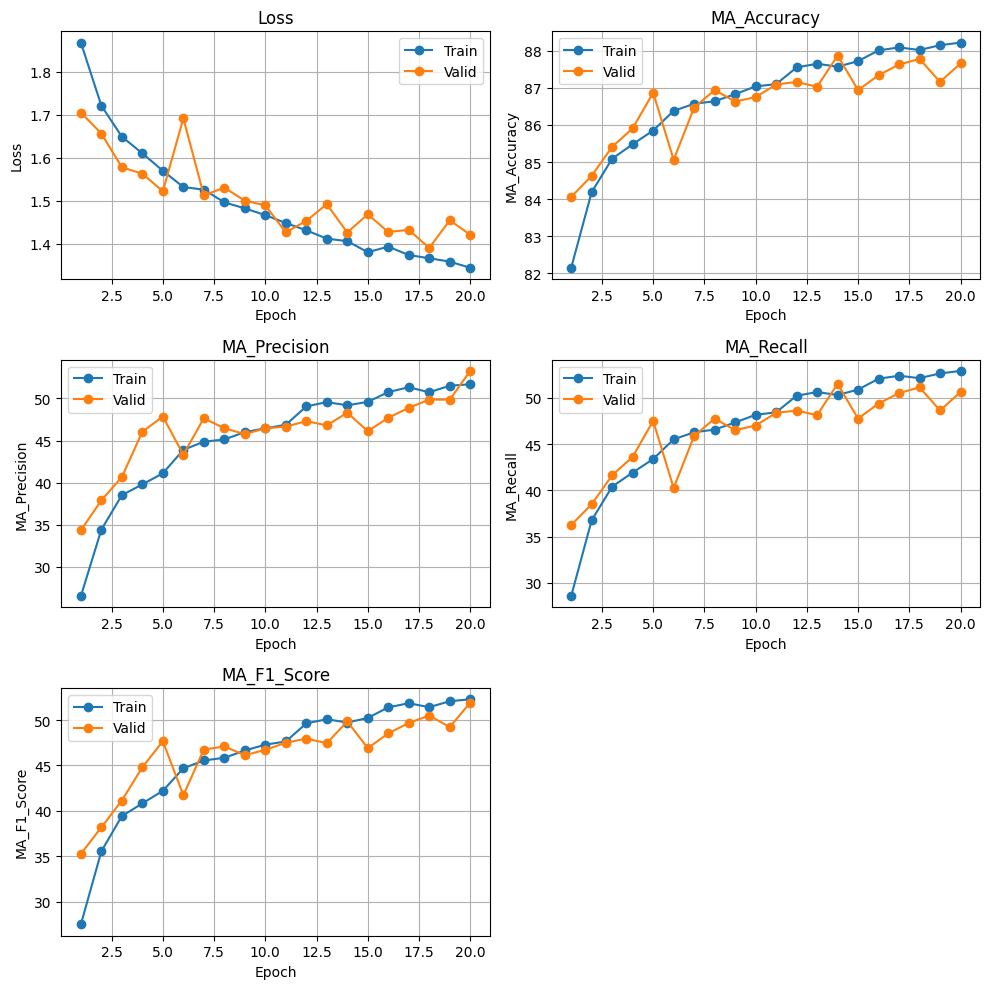

In [ ]:
plot_metrics('Mfcc_data.csv')

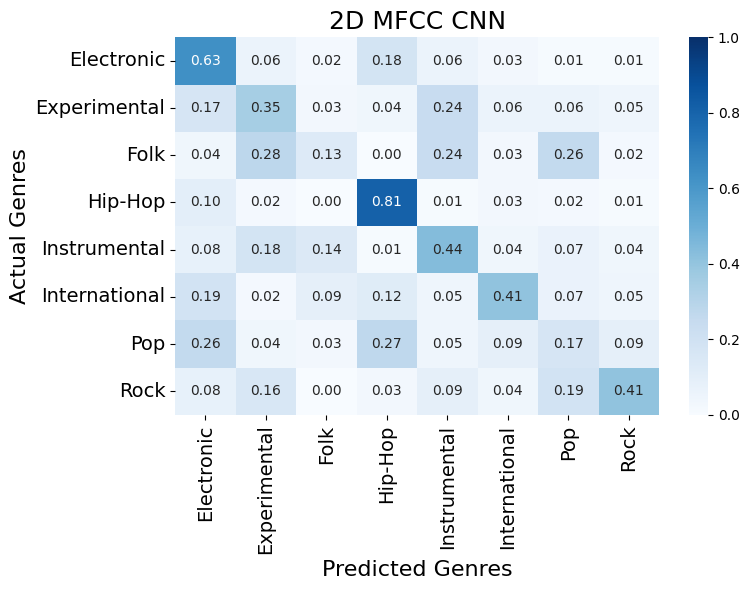

In [ ]:
plot_CM(matrix_file='confusion_matrix_mfcc.csv', plot_title='2D MFCC CNN')

###Late Fusion Network RCNN

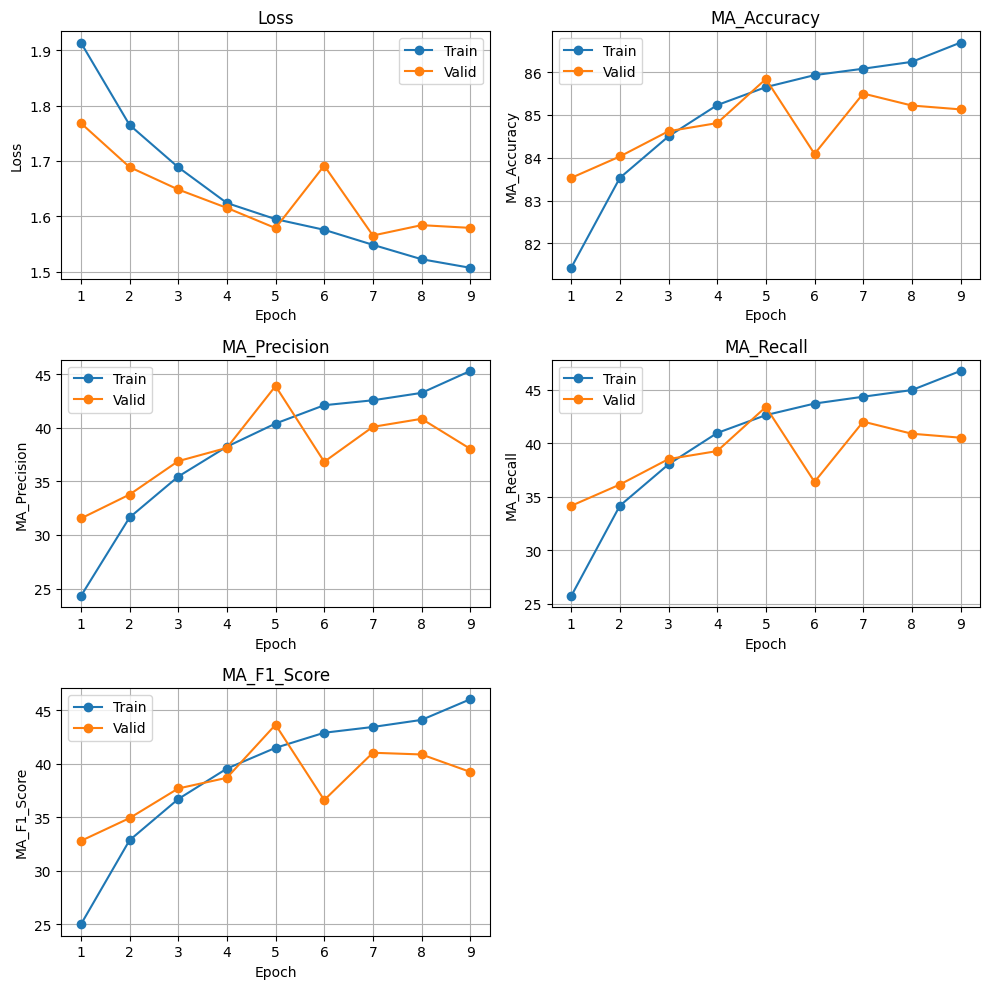

In [ ]:
plot_metrics('LateFusion_data.csv')

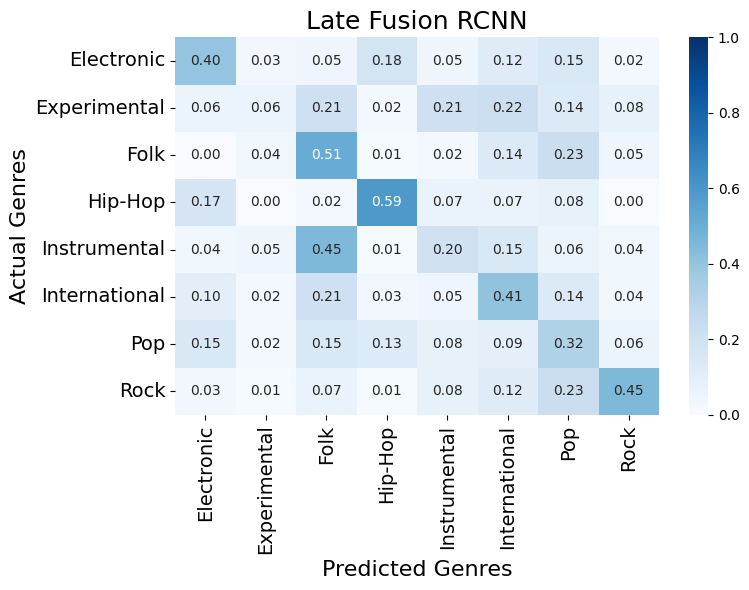

In [110]:
plot_CM(matrix_file='fusion_confusion_matrix.csv', plot_title='Late Fusion RCNN')

### Ensemble Classifier Mode 1

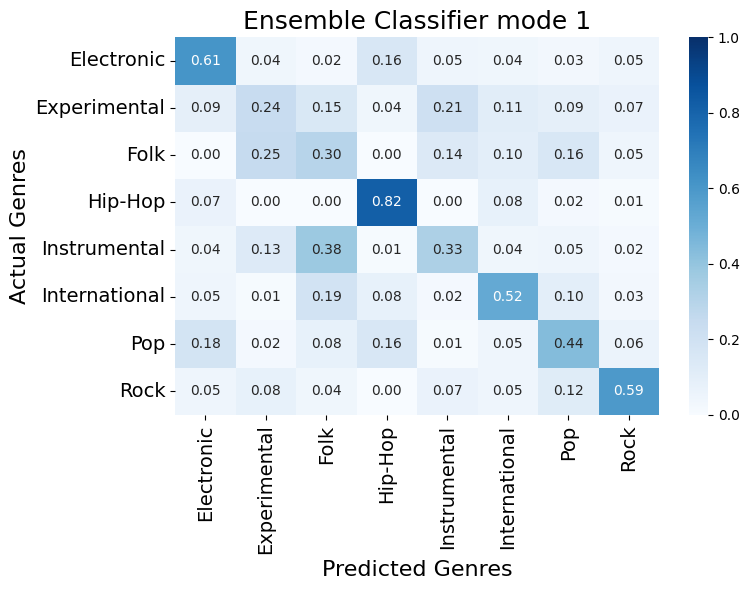

In [ ]:
plot_CM(matrix_file='confusion_matrix_sum1.csv', plot_title='Ensemble Classifier mode 1')

### Ensemble Classifier Mode 2

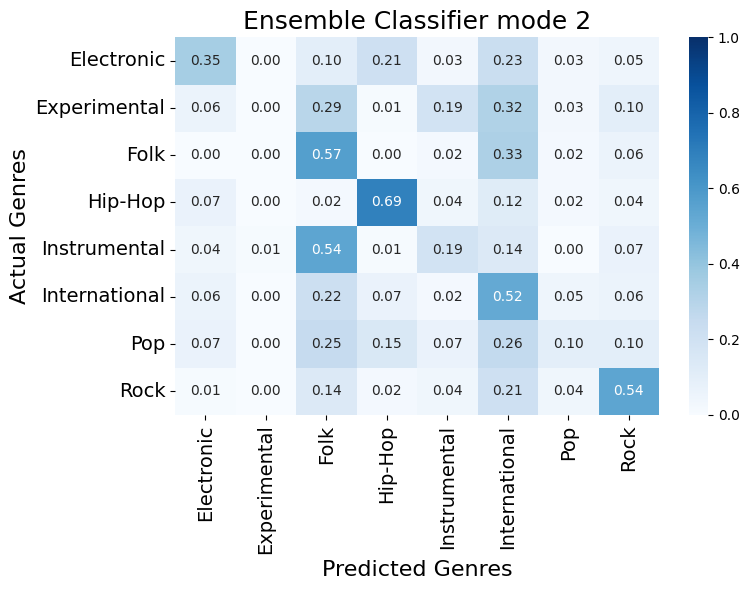

In [ ]:
plot_CM(matrix_file='confusion_matrix_sum2.csv', plot_title='Ensemble Classifier mode 2')

### Comparison


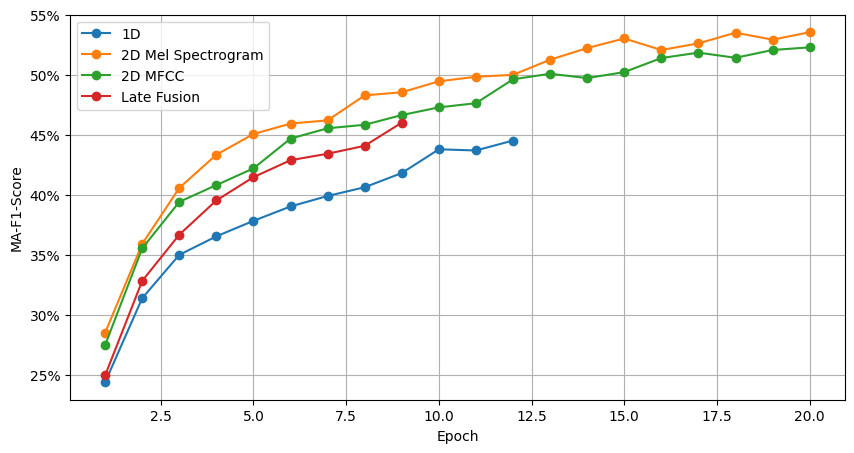

In [112]:
# Load all the CSV files into DataFrames
df_1d = pd.read_csv('1D_data.csv')
df_2d = pd.read_csv('MelSpec_data.csv')
df_crnn = pd.read_csv('Mfcc_data.csv')
df_mmcrnn = pd.read_csv('LateFusion_data.csv')

# Plot F1 score for all the different networks
plt.figure(figsize=(10, 5))

plt.plot(df_1d['Epoch'], df_1d['Train_MA_F1_Score'], label='1D', marker='o')
plt.plot(df_2d['Epoch'], df_2d['Train_MA_F1_Score'], label='2D Mel Spectrogram', marker='o')
plt.plot(df_crnn['Epoch'], df_crnn['Train_MA_F1_Score'], label='2D MFCC', marker='o')
plt.plot(df_mmcrnn['Epoch'], df_mmcrnn['Train_MA_F1_Score'], label='Late Fusion', marker='o')

plt.gca().yaxis.set_major_formatter(lambda y, _: f'{y:.0f}%')

# plt.title('F1-Score for the training epochs')
plt.xlabel('Epoch')
plt.ylabel('MA-F1-Score')
plt.legend()
plt.grid(True)
plt.show()

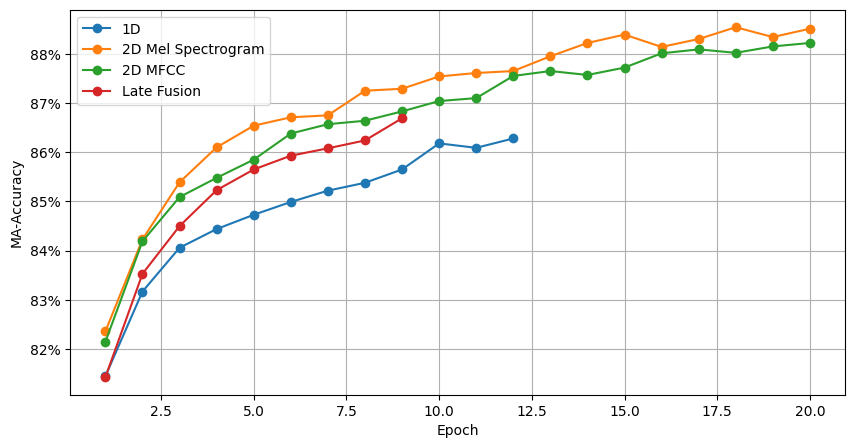

In [111]:
# Plot F1 score for all the different networks
plt.figure(figsize=(10, 5))

plt.plot(df_1d['Epoch'], df_1d['Train_MA_Accuracy'], label='1D', marker='o')
plt.plot(df_2d['Epoch'], df_2d['Train_MA_Accuracy'], label='2D Mel Spectrogram', marker='o')
plt.plot(df_crnn['Epoch'], df_crnn['Train_MA_Accuracy'], label='2D MFCC', marker='o')
plt.plot(df_mmcrnn['Epoch'], df_mmcrnn['Train_MA_Accuracy'], label='Late Fusion', marker='o')

plt.gca().yaxis.set_major_formatter(lambda y, _: f'{y:.0f}%')

# plt.title('F1-Score for the training epochs')
plt.xlabel('Epoch')
plt.ylabel('MA-Accuracy')
plt.legend()
plt.grid(True)
plt.show()